In [1]:
import os
import sys
sys.path.append(os.getcwd())
sys.path.insert(0, "../zeolite-property-prediction/code/")
sys.path.insert(0, "../zeolite-property-prediction/")


import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import matplotlib.pyplot as plt
import matplotlib.ticker as tick

from tqdm import tqdm

from scipy.stats import gaussian_kde
from sklearn.metrics import r2_score

from models.equivariant_mpnn import MPNNPORE
from utils.ZeoliteData import get_zeolite, get_data_pore
from utils.dataloading import get_data, get_graph_data


In [2]:
import matplotlib as mpl

In [3]:
plt.rc('font', family='serif',)


In [4]:
from matplotlib import rc

In [5]:
data = get_zeolite('RHO', True)
    
ref = data['ref'] # reflections
tra = data['tra'] # translations
l = data['l'] # scale of the unit cell

# specific for MOR
atoms, hoa, X, A, d, X_pore, A_pore, d_pore, pore = get_data(l, 'RHO')

edges, idx1, idx2, idx2_oh = get_graph_data(A, d)
edges_sp, idx1_sp, idx2_sp, idx2_oh_sp = get_graph_data(A_pore, d_pore)
edges_ps, idx1_ps, idx2_ps, idx2_oh_ps = get_graph_data(A_pore.T, d_pore.T)

In [6]:
_, testloader, trainloader = get_data_pore(atoms, hoa, edges, pore, edges_sp, edges_ps, bs=32, random=True)

In [7]:
title_size=7.5
label_size=7

In [8]:
mpnn = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, out_size=2).to('cuda')


mpnn2 = MPNNPORE(idx1.to('cuda'), idx2.to('cuda'), idx2_oh.to('cuda'), X, X_pore, ref, tra,
                    idx1_sp.to('cuda'), idx2_sp.to('cuda'), idx2_oh_sp.to('cuda'), 
                    idx1_ps.to('cuda'), idx2_ps.to('cuda'), idx2_oh_ps.to('cuda'),
                    hid_size=[8]*6, site_emb_size=8, edge_emb_size=8, mlp_size=24,
                    centers=10, mx_d=6, width=1, pool='sum', pool_pore=True, site_pred=True, out_size=2).to('cuda')

In [9]:
def get_95_CI(x):
    
    ci = 1.96*np.std(x)/np.sqrt(len(x))
    return ci

In [10]:
_mae_p_hoa = []
_mae_p_henry = []
_mse_p_hoa = []
_mse_p_henry = []
_r2_p_hoa = []
_r2_p_henry = []


_mae_p2_hoa = []
_mse_p2_hoa = []
_mae_p2_henry = []
_mse_p2_henry = []
_r2_p2_hoa = []
_r2_p2_henry = []
    
for j in tqdm(range(1,11)):

    mpnn.load_state_dict(torch.load(f'model_data_random/RHO/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn.predict(testloader)
    y_true[:,1] = torch.log10(y_true[:,1])
    
    _mse = ((y_pred - y_true)**2)#.mean().item()
    _mae = (y_pred - y_true).abs()#.mean().item()

    _r2_hoa = r2_score(y_true[:,0].numpy(), y_pred[:,0].numpy())
    _r2_henry = r2_score(y_true[:,1].numpy(), y_pred[:,1].numpy())
    
    _mae_hoa = _mae[:,0].mean().item()
    _mae_henry = _mae[:,1].mean().item()
    _mse_hoa = _mse[:,0].mean().item()
    _mse_henry = _mse[:,1].mean().item()
    
    _mae_p_hoa.append(_mae_hoa)
    _mae_p_henry.append(_mae_henry)
    _mse_p_hoa.append(_mse_hoa)
    _mse_p_henry.append(_mse_henry)
    _r2_p_hoa.append(_r2_hoa)
    _r2_p_henry.append(_r2_henry)

    
    
    mpnn2.load_state_dict(torch.load(f'model_data_random2/RHO/1.0/pore/model_{j}/model.pth'))
    y_pred, y_true = mpnn2.predict(testloader)
    y_true[:,1] = torch.log10(y_true[:,1])
    
    _mse = ((y_pred - y_true)**2)#.mean().item()
    _mae = (y_pred - y_true).abs()#.mean().item()


    _r2_hoa = r2_score(y_true[:,0].numpy(), y_pred[:,0].numpy())
    _r2_henry = r2_score(y_true[:,1].numpy(), y_pred[:,1].numpy())
    
    _mae_hoa = _mae[:,0].mean().item()
    _mae_henry = _mae[:,1].mean().item()
    _mse_hoa = _mse[:,0].mean().item()
    _mse_henry = _mse[:,1].mean().item()
    
    
    _mae_p2_hoa.append(_mae_hoa)
    _mae_p2_henry.append(_mae_henry)
    _mse_p2_hoa.append(_mse_hoa)
    _mse_p2_henry.append(_mse_henry)
    _r2_p2_hoa.append(_r2_hoa)
    _r2_p2_henry.append(_r2_henry)
    
mae_p_hoa  = np.mean(_mae_p_hoa)
mse_p_hoa = np.mean(_mse_p_hoa)
r2_p_hoa = np.mean(_r2_p_hoa)
mae_p2_hoa  = np.mean(_mae_p2_hoa)
mse_p2_hoa = np.mean(_mse_p2_hoa)
r2_p2_hoa = np.mean(_r2_p2_hoa)

mae_p_henry  = np.mean(_mae_p_henry)
mse_p_henry = np.mean(_mse_p_henry)
r2_p_henry = np.mean(_r2_p_henry)
mae_p2_henry  = np.mean(_mae_p2_henry)
mse_p2_henry = np.mean(_mse_p2_henry)
r2_p2_henry = np.mean(_r2_p2_henry)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.15it/s]


In [11]:
_mae_p_hoa, _mae_p2_hoa

([1.1750198602676392,
  1.012831449508667,
  2.162036418914795,
  1.1152642965316772,
  1.9463213682174683,
  2.0645482540130615,
  1.5654301643371582,
  1.4993903636932373,
  1.1216754913330078,
  0.754518985748291],
 [1.2255009412765503,
  1.0798420906066895,
  1.657737374305725,
  1.106425404548645,
  0.7471213340759277,
  0.6967174410820007,
  1.0472638607025146,
  0.8653120398521423,
  0.7471498847007751,
  0.9743687510490417])

In [21]:
best_idx = np.argmin(_mae_p2_hoa)
print(best_idx)
mpnn2.load_state_dict(torch.load(f'model_data_random2/RHO/1.0/pore/model_{best_idx+1}/model.pth'))
y_pred, y_true = mpnn2.predict(testloader)

5


In [22]:
y_pred = y_pred.numpy()
y_true = y_true.numpy()
y_true[:,1] = np.log10(y_true[:,1])

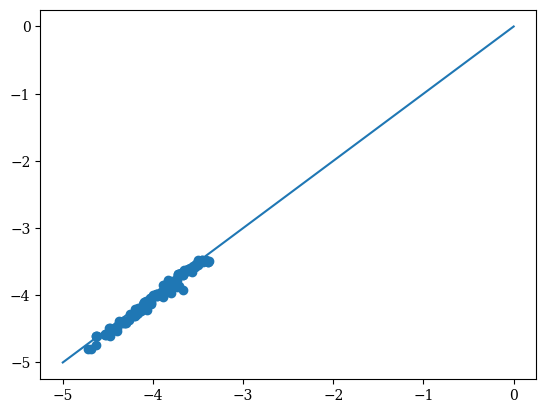

In [14]:
plt.scatter(y_true[:,1], y_pred[:,1])
plt.plot([-5,0],[-5,0])

In [15]:
maes = [_mae_p_hoa, _mae_p2_hoa, _mae_p_henry, _mae_p2_henry]
mses = [_mse_p_hoa, _mse_p2_hoa, _mse_p_henry, _mse_p2_henry]
r2s = [_r2_p_hoa, _r2_p2_hoa, _r2_p_henry, _r2_p2_henry]

In [18]:
df = pd.DataFrame(columns = ['MAE','MSE','R2'], index=['EPCN (hoa)','Ours (hoa)','EPCN (henry)', 'Ours (henry)'])
for i in range(len(df.index)):

    mu_a = np.mean(maes[i]).round(2)
    mu_s = np.mean(mses[i]).round(2)
    mu_r = np.mean(r2s[i]).round(2)
    
    ci_a = get_95_CI(maes[i]).round(2)
    ci_s = get_95_CI(mses[i]).round(2)
    ci_r = get_95_CI(r2s[i]).round(2)
    
    a = fr'{mu_a} $$\pm$$ {ci_a}'
    s = fr'{mu_s} $$\pm$$ {ci_s}'
    r = fr'{mu_r} $$\pm$$ {ci_r}'
    
    df.loc[df.index[i]] = [a,s,r]

In [19]:
df

,MAE,MSE,R2
EPCN (hoa),1.44 $$\pm$$ 0.29,3.0 $$\pm$$ 0.99,0.66 $$\pm$$ 0.11
Ours (hoa),1.01 $$\pm$$ 0.17,1.62 $$\pm$$ 0.43,0.82 $$\pm$$ 0.05
EPCN (henry),0.22 $$\pm$$ 0.07,0.06 $$\pm$$ 0.03,0.48 $$\pm$$ 0.25
Ours (henry),0.12 $$\pm$$ 0.06,0.03 $$\pm$$ 0.02,0.77 $$\pm$$ 0.19


In [23]:
np.save('pred_rho.npy', y_pred)

In [25]:
np.save('true_rho.npy', y_true)
np.save('ats_rho.npy',testloader.dataset.X.numpy())

In [16]:
color = np.zeros((X.shape[0],))
for i in range(len(X)):
    
    for j in range(4):
        
        for k in range(ref.shape[0]):
            
            if np.abs(X[i] - (np.mod(X[j]@ref[k] + tra[k], 1))).sum() < 0.001:
                
                color[i] = j
                
                break


color2 = np.zeros((X_pore.shape[0],))
for i in range(len(X_pore)):
    
    for j in [0,1]:
        
        for k in range(ref.shape[0]):
            
            if np.abs(X_pore[i] - (np.mod(X_pore[j]@ref[k] + tra[k], 1))).sum() < 0.001:
                
                color2[i] = j
                
                break

In [17]:
X[0], X[0]@ref[2], ref[2]@X[0]

(array([0.25 , 0.104, 0.396]),
 array([0.396, 0.25 , 0.104]),
 array([0.104, 0.396, 0.25 ]))

In [18]:
ref[2]

array([[0., 1., 0.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [19]:
ce_dict = {}
row, col = np.nonzero(A)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in ce_dict:
        
        if added: break
        
        test = ce_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(X[r]@ref[k] + tra[k], 1)
            r2 = np.mod(X[c]@ref[k] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.05 and np.abs(r2-test_c).sum() < 0.05:
                
                ce_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        ce_dict[n_c] = [(r,c)]
        n_c += 1

In [20]:
n_c

2

In [21]:
cp_dict = {}
row, col = np.nonzero(A_pore)
n_c = 0
for i in range(len(row)):
    
    added = False
    
    r,c = row[i], col[i]
    
    for j in cp_dict:
        
        if added: break
        
        test = cp_dict[j][0]
        
        test_r = X[test[0]]
        test_c = X_pore[test[1]]
        
        
        for k in range(ref.shape[0]):
            
            r1 = np.mod(X[r]@ref[k] + tra[k], 1)
            r2 = np.mod(X_pore[c]@ref[k] + tra[k], 1)
            
            if np.abs(r1-test_r).sum() < 0.001 and np.abs(r2-test_c).sum() < 0.001:
                
                cp_dict[j].append((r,c))
                
                added = True
                break
        
    if not added:
        cp_dict[n_c] = [(r,c)]
        n_c += 1

In [22]:
n_c

1

In [23]:
import matplotlib.patheffects as pe

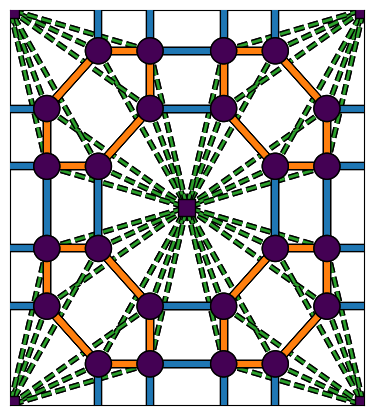

In [24]:
cs = []
plt.figure(figsize=(18.256/4, 20.534/4))
for i in ce_dict:
    x = 0
    for j in ce_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=4, zorder=5)
            plt.plot([x1[0], x2[0]], [x1[1], x2[1]], lw=6, c='black', zorder=4)
            #cs.append(line[0].get_c())
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=4, zorder=5)
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= 'black',lw=6, zorder=4)
        x+=1
        
        
for i in cp_dict:
    x = 0
    for j in cp_dict[i]:
        
        x1, x2 = X[j[0]].copy(), X_pore[j[1]].copy()
        
        d = x2-x1
        
        for _d in range(3):
            
            if d[_d] > 0.5:
                
                x2[_d] -= 1
            
            elif d[_d] < -.5:
                
                x2[_d] += 1
            
        
        
        
        if x == 0:
            line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
            
        plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black'), pe.Normal()])
        #     line = plt.plot([x1[0], x2[0]], [x1[1], x2[1]],lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        
        # plt.plot([x1[0], x2[0]], [x1[1], x2[1]], c= line[0].get_c(),lw=2,ls='--', path_effects=[pe.Stroke(linewidth=4, foreground='black')])
        x+=1
        

plt.scatter(X_pore[:,0], X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1], s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0], X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.scatter(X_pore[:,0]+1, X_pore[:,1]+1, s=150, zorder=10, c=color2, marker='s', edgecolors='black')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xticks([],[])
plt.yticks([],[])
plt.scatter(X[:,0], X[:,1], c=color, s=350, zorder=10, edgecolors='black')
# plt.scatter(X[:,0], X[:,1], c='black', s=500, zorder=9)
plt.savefig('figures/weight_sharing_pore_RHO.pdf', bbox_inches='tight', dpi=1200);
plt.savefig('figures/weight_sharing_pore_RHO.png', bbox_inches='tight', dpi=1200);